# Polynomial Derivatives

$ p_t = c_0 + c_1 t + c_2 t^2 + c_3 t^3 + c_4 t^4\dots + c_n t^n = \sum\limits_{k=0}^{n} c_k t^k$

$\dot{p_t} = c_1 + c_2 2 t + c_3 3 t^2 + c_4 3 t^3 + \dots + c_n n t^n = \sum\limits_{k=1}^{n} c_k k t^{k-1}$

$\ddot{p_t} = c_2 2 + c_3 6 t + c_4 12 t^2\dots = \sum\limits_{k=2}^{n} c_k k(k-1) t^{k-2}$

$\ddot{p_t} = c_3 6 + c_4 28 t\dots = \sum\limits_{k=3}^{n} c_k k(k-1)(k-2) t^{k-3}$

$p_t^{(m)} = \sum\limits_{k=m}^{n} c_{k} \frac{!k}{!(k-m)} t^{k-m}$

# Polynomial Derivatives with Time Scaling

$ \beta = t/T$

$ \dot{\beta} = 1/T$

$ p_\beta = c_0 + c_1 T \beta + c_2 T^2 \beta^2 + c_3 T^3 \beta^3 + c_4 T^4 \beta^4\dots = \sum\limits_{k=0}^{n} c_k T^k \beta^k$

$ \dot{p_{\beta}} = \dfrac{dp}{d\beta} \dfrac{d \beta}{dt} = (c_1 T + c_2 2 T^2 \beta + c_3 3 T^3 \beta^2 + c_4 4 T^4 \beta^3\dots) /T = \sum\limits_{k=1}^{n} c_k k T^{k-1} \beta^{k-1}$

$p_{\beta}^{(m)} = \sum\limits_{k=m}^{n} c_{k} \frac{!k}{!(k-m)} T^{k-m} \beta^{k-m}$

$
\begin{bmatrix}
p(t) \\
p(0) \\
p(1) \\
\dot{p}(t) \\
\end{bmatrix} = 
\begin{bmatrix}
1 & T \beta & T^2 \beta^2 & \dots & T^n \beta^n \\
1 & 0 & 0 & \dots & 0\\
0 & 1 & 2 T \beta & 3 T^2 \beta^2 & \dots & T_n\\
\end{bmatrix}
\begin{bmatrix}
c_0 \\
c_1 \\
c_2 \\
\vdots \\
c_n
\end{bmatrix}
$

In [3]:
import numpy as np
import logging
import sys

import importlib
importlib.reload(logging)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')


class PolyTraj:
    
    def __init__(self, poly_order, coeff, leg_times):
        assert len(leg_times) == len(coeff)/(poly_order + 1)
        self.poly_order = poly_order
        self.leg_times = leg_times
        self.poly_leg = [
            np.polynomial.Polynomial(coeff[j*(poly_order+1):(j+1)*(poly_order+1)])
            for j in range(len(leg_times))\
        ]
        self.t_start_leg = np.cumsum(np.hstack([0, self.leg_times]))

    
    def __call__(self, t, m=0):
        t = np.atleast_1d(t)
        t_start = t[np.argwhere(t < 0)]
        vals = self.poly_leg[0].deriv(m)(0)*np.ones(len(t_start))
        for i_leg in range(len(self.leg_times)):
            t_i = t[np.argwhere(np.logical_and(t >= self.t_start_leg[i_leg], t < self.t_start_leg[i_leg+1]))]
            if len(t_i) == 0:
                continue
            beta = (t_i - self.t_start_leg[i_leg])/self.leg_times[i_leg]
            vals = np.hstack([vals, self.poly_leg[i_leg].deriv(m)(beta)[:, 0]])
        t_end = t[np.argwhere(t >= self.t_start_leg[len(self.leg_times)])]
        vals = np.hstack([vals, self.poly_leg[-1].deriv(m)(1)*np.ones(len(t_end))])
        return vals

def plan_trajectory_1d(poly_order, waypoints, leg_times, stop_derivs, continuity_derivs):

    def constraint_eq(poly_order, derivative, scaled_time, leg_time, i_leg, n_legs):
        n = poly_order
        m = derivative
        beta = scaled_time
        T = leg_time
        a = np.zeros(n_legs*(n+1))
        for k in range(m, n+1):
            l = 1
            for j in range(k, k-m, -1):
                l *= j
            #assert l == np.math.factorial(k)/np.math.factorial(k-m)
            a[i_leg*(n+1) + k] = l*T**(k-m)*beta**(k-m)
        return a

    waypoints = np.atleast_1d(waypoints)
    A = []
    b = []
    n_legs = len(leg_times)
    assert len(leg_times) == len(waypoints) - 1
    
    n_constraints = 0
    
    # waypoints
    for i_leg, leg_time in enumerate(leg_times):
        # start
        logging.info('leg %d start ', i_leg)
        A.append(constraint_eq(poly_order=poly_order, derivative=0, scaled_time=0, leg_time=leg_time, i_leg=i_leg, n_legs=n_legs))
        b.append(waypoints[i_leg])
        n_constraints += 1

        # end
        logging.info('leg %d end', i_leg)
        A.append(constraint_eq(poly_order=poly_order, derivative=0, scaled_time=1, leg_time=leg_time, i_leg=i_leg, n_legs=n_legs))
        b.append(waypoints[i_leg + 1])
        n_constraints += 1


    # stop
    for m in stop_derivs:
        # start stopped
        logging.info('stopped at start %d', m)
        A.append(constraint_eq(poly_order=poly_order, derivative=m, scaled_time=0, leg_time=leg_time, i_leg=0, n_legs=n_legs))
        b.append(0)
        n_constraints += 1

        # end stopped
        logging.info('stopped at end %d', m)
        if n_constraints == n_legs*(poly_order+1):
            break
        A.append(constraint_eq(poly_order=poly_order, derivative=m, scaled_time=1, leg_time=leg_time, i_leg=n_legs-1, n_legs=n_legs))
        b.append(0)
        n_constraints += 1

    # continuity
    for m in continuity_derivs:
        for i_leg in range(len(leg_times) - 1):
            # start
            logging.info('leg %d continuity %d', i_leg, m)
            A.append(constraint_eq(poly_order=poly_order, derivative=m, scaled_time=1, leg_time=leg_time, i_leg=i_leg, n_legs=n_legs)
                     - constraint_eq(poly_order=poly_order, derivative=m, scaled_time=0, leg_time=leg_time, i_leg=i_leg+1, n_legs=n_legs)
                    )
            b.append(0)
            n_constraints += 1


    A = np.array(A)
    b = np.array(b)
    
    logging.info('n_constraints: %d', n_constraints)
    logging.info('n_coeff: %d', poly_order + 1)
    
    assert n_constraints <= n_legs*(poly_order + 1)
    
    coeff = np.linalg.pinv(A).dot(b)
    return PolyTraj(poly_order=poly_order, coeff=coeff, leg_times=leg_times)

In [ ]:
def plan_trajectory_2d(poly_order=, waypoints, leg_times, stop_derivs, continuity_derivs):
    

07:28:20 INFO:leg 0 start 
07:28:20 INFO:leg 0 end
07:28:20 INFO:leg 1 start 
07:28:20 INFO:leg 1 end
07:28:20 INFO:stopped at start 1
07:28:20 INFO:stopped at end 1
07:28:20 INFO:leg 0 continuity 1
07:28:20 INFO:n_constraints: 7
07:28:20 INFO:n_coeff: 4


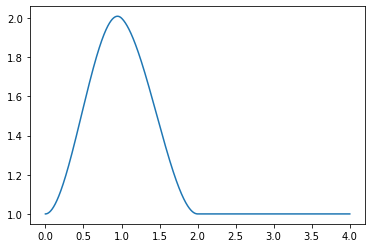

In [4]:
import matplotlib.pyplot as plt
p = plan_trajectory_1d(poly_order=3, waypoints=[1, 2, 1], leg_times=[1, 1], stop_derivs=[1], continuity_derivs=[1])
t = np.linspace(0, 4, 10000)
plt.plot(t, p(t, 0))